# Examples of Making Sky Plots from BOSS Meta Data

Examples of using the [Basemap](http://matplotlib.org/basemap/) and [healpy](https://healpy.readthedocs.org/en/latest/) packages to make all sky maps of meta data accessed with the [bossdata](http://bossdata.readthedocs.org/) package.  We use data from the BOSS quasar catalog.

## Package Initialization

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PolyCollection

In [3]:
import astropy.units as u
from astropy.coordinates import SkyCoord

In [4]:
import healpy as hp
print hp.version.__version__

1.8.6


In [5]:
import bossdata.meta
print bossdata.__version__

0.2.7dev


## Sky Plots

Get list of ra, dec, z for high redshift quasar observations

In [6]:
quasar_catalog = bossdata.meta.Database(quasar_catalog=True)

In [7]:
quasar_table = quasar_catalog.select_all(what='RA,DEC,Z_VI', where='Z_VI > 2.1 and Z_VI < 3.5', max_rows=0)
print 'Found {0} high redshift quasars (2.1 < z < 3.5).'.format(len(quasar_table))

Found 181605 high redshift quasars (2.1 < z < 3.5).


Plot an "all sky map" using healpix binning:

In [8]:
def plot_sky(ra, dec, data=None, nside=16, label='', projection='eck4', cmap=plt.get_cmap('jet'), norm=None):
    # get pixel area in degrees
    pixel_area = hp.pixelfunc.nside2pixarea(nside, degrees=True)
    # find healpixels associated with input vectors
    pixels = hp.ang2pix(nside, 0.5*np.pi-np.radians(dec), np.radians(ra))
    # find unique pixels
    unique_pixels = np.unique(pixels)
    # count number of points in each pixel
    bincounts = np.bincount(pixels)
    # if no data provided, show counts per sq degree
    # otherwise, show mean per pixel
    if data is None:
        values = bincounts[unique_pixels]/pixel_area
    else:
        weighted_counts = np.bincount(pixels, weights=data)
        values = weighted_counts[unique_pixels]/bincounts[unique_pixels]
    # find pixel boundaries
    corners = hp.boundaries(nside, unique_pixels, step=1)
    corner_theta, corner_phi = hp.vec2ang(corners.transpose(0,2,1))
    corner_ra, corner_dec = np.degrees(corner_phi), np.degrees(np.pi/2-corner_theta)
    # set up basemap
    m = Basemap(projection=projection, lon_0=90, resolution='l', celestial=True)
    m.drawmeridians(np.arange(0, 360, 30), labels=[0,0,1,0], labelstyle='+/-')
    m.drawparallels(np.arange(-90, 90, 15), labels=[1,0,0,0], labelstyle='+/-')
    m.drawmapboundary()
    # convert sky coords to map coords 
    x,y = m(corner_ra, corner_dec)
    # regroup into pixel corners
    verts = np.array([x.reshape(-1,4), y.reshape(-1,4)]).transpose(1,2,0)
    # Make the collection and add it to the plot.
    coll = PolyCollection(verts, array=values, cmap=cmap, norm=norm, edgecolors='none')
    plt.gca().add_collection(coll)
    plt.gca().autoscale_view()
    # Add a colorbar for the PolyCollection
    plt.colorbar(coll, orientation='horizontal', pad=0.05, label=label)
    return m

#### Show distribution on sky

Plot the number of quasars per square degree:

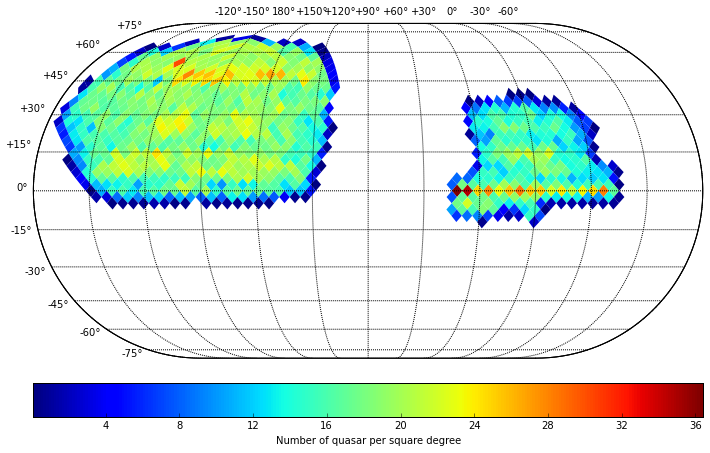

In [9]:
plt.figure(figsize=(12,9))
plot_sky(quasar_table['RA'].data, quasar_table['DEC'].data, label='Number of quasar per square degree')
plt.show()

#### Show mean redshift on sky

We can show the mean value of a quantity on the sky as well

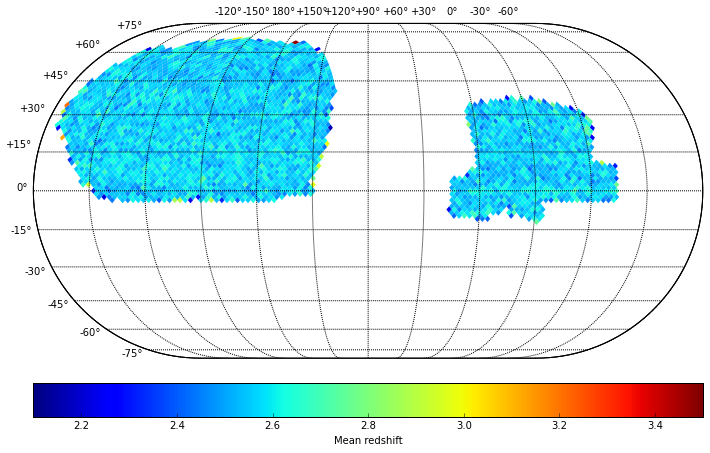

In [10]:
plt.figure(figsize=(12,9))
plot_sky(quasar_table['RA'].data, quasar_table['DEC'].data, data=quasar_table['Z_VI'].data,
         label='Mean redshift', nside=32,
         norm=mpl.colors.Normalize(vmin=2.1, vmax=3.5))
plt.show()

#### Show galactic plane

Use astropy to show the galactic plane

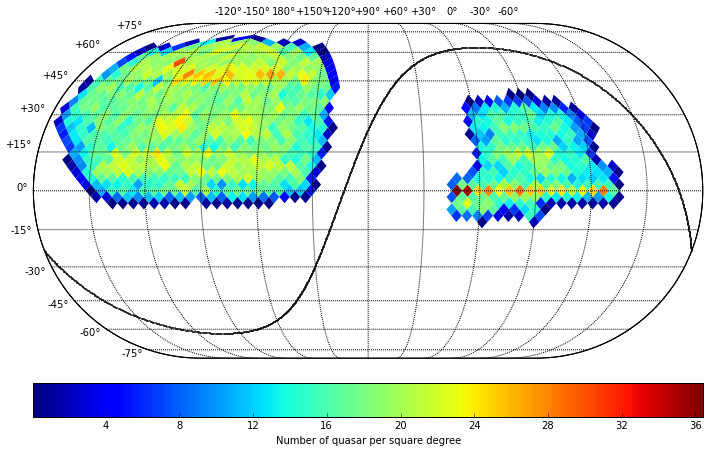

In [11]:
plt.figure(figsize=(12,9))
m = plot_sky(quasar_table['RA'].data, quasar_table['DEC'].data, label='Number of quasar per square degree')
# generate vector in galactic coordinates  and convert to equatorial coordinates
galactic_l = np.linspace(0, 2*np.pi, 1000)
galactic_plane = SkyCoord(l=galactic_l*u.radian, b=np.zeros_like(galactic_l)*u.radian, frame='galactic').fk5
# project to map coordinates
x, y = m(galactic_plane.ra.degree, galactic_plane.dec.degree)
m.scatter(x, y, marker='.', s=2, c='k')
plt.show()